In [1]:
import torch, torchvision
from torchvision import transforms, models
import numpy as np
from BASNet.model.BASNet import BASNet
from PIL import Image

from utils import load_segmentation_model, show_images, get_positive_image_pair, get_negative_images
from mask_contrast import MaskContrastLoss

import matplotlib.pyplot as plt

In [2]:
train_dir='./Vegetable Images/train'
val_dir='./Vegetable Images/validation'
test_dir='./Vegetable Images/test'

In [3]:
VEGETABLE_CLASSES = ['Bean', 'Bitter Gourd', 'Bottle Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
NUM_CLASSES = len(VEGETABLE_CLASSES)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomRotation(15),
                                     transforms.ColorJitter(brightness=0.2,contrast=0.1,hue=0.1,saturation=0.1),
                                     transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(1, 2), shear=15),
                                     transforms.GaussianBlur(kernel_size=(5,9)),
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     normalize
                                     ])

test_transform = transforms.Compose([                             
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor(), 
                                     normalize
                                     ])

In [5]:
num_epochs = 10
test_frequency = 5
batch_size = 5

train_dataset=torchvision.datasets.ImageFolder(root=train_dir,transform=train_transform)
val_dataset=torchvision.datasets.ImageFolder(root=val_dir,transform=test_transform)
test_dataset=torchvision.datasets.ImageFolder(root=test_dir,transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=1)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=1)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=batch_size, 
                                               shuffle=False,
                                               num_workers=1)

In [6]:
def train_segmentation(train_loader, segmentation_net, saliency_net, criterion, optimizer):
    segmentation_net.train()
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        main_images = []
        positive_images = []
        negative_images = []
        
        object_masks = saliency_net(images)
        for i in range(len(images)):  
            object_mask = object_masks[i]
            
            main_image, positive_image = get_positive_image_pair(images[i], object_mask)
            negative_image = get_negative_images(images[i], object_mask)
            
            main_images.append(main_image)
            positive_images.append(positive_image)
            negative_images = negative_images + negative_image
            
        main_images = torch.stack(main_images)
        positive_images = torch.stack(positive_images)
        negative_images = torch.stack(negative_images)
        
        main_image_embedding = segmentation_net(main_images)['out'][:, 0, :, :]
        positive_image_embedding = segmentation_net(positive_images)['out'][:, 0, :, :]
        negative_image_embeddings = segmentation_net(negative_images)['out'][:, 0, :, :]
        negative_image_embeddings = negative_image_embeddings.view(batch_size, 128, -1, -1, -1)
            
        optimizer.zero_grad()
        loss = criterion(main_image_embeddings, positive_image_embeddings, negative_image_embeddings)
        loss.backward()
        optimizer.step()
        losses.append(loss)
        
        print(f'{(i + 1) * batch_size} / {len(train_loader.dataset)} images trained')
    
    return torch.stack(losses).mean().item()

def test_segmentation(test_loader, segmentation_net, saliency_net, criterion, print_ind_classes=True, print_total=True):
    segmentation_net.eval()
    losses = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            main_images = []
            positive_images = []
            negative_images = []

            object_masks = saliency_net(images)
            for i in range(len(images)):
                object_mask = object_masks[i]
                
                main_image, positive_image = get_positive_image_pair(images[i], object_mask)
                negative_image = get_negative_images(image, object_mask)

                main_images.append(main_image)
                positive_images.append(positive_image)
                negative_images = negative_images + negative_image
            print('hi')
            main_images = torch.stack(main_images)
            positive_images = torch.stack(positive_images)
            negative_images = torch.stack(negative_images)

            main_image_embedding = segmentation_net(main_images)['out'][:, 0, :, :]
            positive_image_embedding = segmentation_net(positive_images)['out'][:, 0, :, :]
            negative_image_embeddings = segmentation_net(negative_images)['out'][:, 0, :, :]
            negative_image_embeddings = negative_image_embeddings.view(batch_size, 128, -1, -1, -1)
            
            loss = criterion(main_image_embeddings, positive_image_embeddings, negative_image_embeddings)
            losses.append(loss.item())
        
    return test_loss, logits

def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [7]:
def train(segmentation_net, saliency_net, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler, test_frequency=5):
    train_losses = []
    train_mAPs = []
    val_losses = []
    val_mAPs = []

    for epoch in range(1,num_epochs+1):
        print("Starting epoch number " + str(epoch))
        train_loss = train_segmentation(train_loader, segmentation_net, saliency_net, criterion, optimizer)
        train_losses.append(train_loss)
        print("Loss for Training on Epoch " + str(epoch) + " is " + str(train_loss))
        if(epoch%test_frequency==0 or epoch==1):
            val_loss, logits = test_segmentation(val_loader, segmentation_net, saliency_net, criterion)
            print('Evaluating classifier')
            
            #Find some way of displaying segmentation results
            show_images(logits)
            
            val_losses.append(val_loss)
            
            scheduler.step()
    
    return segmentation_net, train_losses, val_losses

### Load Neural Nets

In [8]:
# basnet.forward returns a list of 8 saliency estimations. For simplicity we will just use the first estimation 
basnet = BASNet(3, NUM_CLASSES).to(device)
basnet.load_state_dict(torch.load('saved_models/basnet.pth'))

segmentation_net = load_segmentation_model().to(device)

Using cache found in C:\Users\james/.cache\torch\hub\pytorch_vision_v0.6.0


In [9]:
# criterion = MaskContrastLoss

# optimizer = torch.optim.SGD(segmentation_net.parameters(), lr=0.004, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.9)

# segmentation_net, train_losses, val_losses = train(segmentation_net, basnet, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler, test_frequency)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


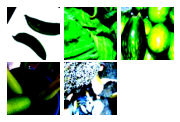

In [10]:
images, labels = next(iter(train_loader))
show_images(images, color=True)

In [11]:
segmented_images = []
basnet_images = []

use_basnet = True
for image in images:
    image = image.unsqueeze(0).to(device)
    
    if use_basnet:
        basnet_images.append(basnet(image)[0].squeeze().cpu())
    else:
        segmented_images.append(segmentation_net(image)['out'].squeeze()[0].cpu())

C:\Users\james\anaconda3\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\james\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [12]:
if use_basnet:
    basnet_images = torch.stack(basnet_images).detach().numpy()
else:
    segmented_images = torch.stack(segmented_images).detach().numpy()

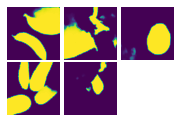

In [13]:
if use_basnet:
    show_images(basnet_images)
else:
    show_images(segmented_images)